# <font color=green>LivingEarth Australia - FAO LCCS Level 4</font>

### An environmental layers testing framework for the FAO land cover classification system

### **Import modules**

In [1]:
import numpy
import xarray
import rasterio
from matplotlib import pyplot
import datacube
from datacube.storage import masking
from datacube.helpers import write_geotiff
from datacube.utils.geometry import CRS

# must specific lccs_dev environment for MADs and mangrove datasets
# dc = datacube.Datacube(env='lccs_dev', app="level4")
dc = datacube.Datacube(app="level4")

#import le_lccs modules
import sys
sys.path.append('../../../livingearth_lccs')
from le_lccs.le_ingest import gridded_ingest
from le_lccs.le_classification import lccs_l3
from le_lccs.le_classification import lccs_l4

### **Define are of interest to be loaded**

In [2]:
# # Ayr
# x = (1500000, 1600000)
# y = (-2200000, -2100000)
# min_x = 1500000
# max_x = 1600000
# min_y = -2200000
# max_y = -2100000
# res_x = 100
# res_y = -100

# # Diamentina
# x = (800000, 900000)
# y = (-2800000, -2700000)
# min_x = 800000
# max_x = 900000
# min_y = -2800000
# max_y = -2700000
# res_x = 100
# res_y = -100

# # Gwydir
# x = (1600000, 1700000)
# y = (-3400000, -3300000)
# min_x = 1600000
# max_x = 1700000
# min_y = -3400000
# max_y = -3300000
# res_x = 100
# res_y = -100

# Leichhardt
x = (800000, 900000)
y = (-2000000, -1900000)
min_x = 800000
max_x = 900000
min_y = -2000000
max_y = -1900000
res_x = 100
res_y = -100

# # Kakadu
# x = (0, 100000)
# y = (-1350000, -1250000)
# min_x = 0
# max_x = 100000
# min_y = -1350000
# max_y = -1250000
# res_x = 100
# res_y = -100

# # Hobart
# x = (1200000, 1300000)
# y = (-4800000, -4700000)
# min_x = 1200000
# max_x = 1300000
# min_y = -4800000
# max_y = -4700000
# res_x = 100
# res_y = -100

# # Perth
# x = (-1550000, -1450000)
# y = (-3650000, -3550000)
# min_x = -1550000
# max_x = -1450000
# min_y = -3650000
# max_y = -3550000
# res_x = 100
# res_y = -100

# # Murray Valley
# x = (1100000, 1200000)
# y = (-4000000, -3900000)
# min_x = 1100000
# max_x = 1200000
# min_y = -4000000
# max_y = -3900000
# res_x = 100
# res_y = -100

# # Adelaide
# x = (550000, 650000)
# y = (-3850000, -3750000)
# min_x = 550000
# max_x = 650000
# min_y = -3850000
# max_y = -3750000
# res_x = 100
# res_y = -100

# # Lake Eyre
# x = (500000, 600000)
# y = (-3000000, -2900000)
# min_x = 500000
# max_x = 600000
# min_y = -3000000
# max_y = -2900000
# res_x = 100
# res_y = -100

# # Blue mountains
# x = (1600000, 1700000)
# y = (-3900000, -3800000)
# min_x = 1600000
# max_x = 1700000
# min_y = -3900000
# max_y = -3800000
# res_x = 100
# res_y = -100

# # Australian Alps
# x = (1400000, 1500000)
# y = (-4100000, -4000000)
# min_x = 1400000
# max_x = 1500000
# min_y = -4100000
# max_y = -4000000
# res_x = 100
# res_y = -100

# # Collier Range
# x = (-1300000, -1200000)
# y = (-2700000, -2600000)
# min_x = -1300000
# max_x = -1200000
# min_y = -2700000
# max_y = -2600000
# res_x = 100
# res_y = -100

# # Coorong
# x = (600000, 700000)
# y = (-3950000, -3850000)
# min_x = 600000
# max_x = 700000
# min_y = -3950000
# max_y = -3850000
# res_x = 100
# res_y = -100

# # Brisbane
# x = (2000000, 2100000)
# y = (-3200000, -3100000)
# min_x = 2000000
# max_x = 2100000
# min_y = -3200000
# max_y = -3100000
# res_x = 100
# res_y = -100

# # Mt Ney
# x = (-1000000, -900000)
# y = (-3650000, -3550000)
# min_x = -1000000
# max_x = -900000
# min_y = -3650000
# max_y = -3550000
# res_x = 100
# res_y = -100

res = (-100, 100)
crs = "EPSG:3577"
time = ("2015-01-01", "2015-12-31")
sensor = 'ls8'
query =({'x':x,
        'y':y,
        'crs':crs,
        'resolution':res})

## <font color=blue>Level 3</font>

### 1. Vegetated / Non-Vegetated

In [3]:
# Load data from datacube
fc_ann = dc.load(product="fc_percentile_albers_annual", 
                 measurements=["PV_PC_90", "NPV_PC_90", "BS_PC_90"],
                 time=time, **query)
fc_ann = masking.mask_invalid_data(fc_ann)

In [4]:
# Create binary layer representing vegetated (1) and non-vegetated (0)
vegetat = ((fc_ann["PV_PC_90"] >= 50) | ((fc_ann["NPV_PC_90"] >= 50) & (fc_ann["NPV_PC_90"] <= 80)))

# Convert to Dataset and add name
vegetat_veg_cat_ds = vegetat.to_dataset(name="vegetat_veg_cat").squeeze().drop('time')

In [5]:
# Plot output
# vegetat_veg_cat_ds["vegetat_veg_cat"].plot.imshow(figsize=(6, 5))

### 2. Aquatic / Terrestrial

In [6]:
# Load data from datacube
wofs_ann = dc.load(product="wofs_annual_summary", measurements=["frequency"], 
                     time=time, **query)
wofs_ann = masking.mask_invalid_data(wofs_ann)

item = dc.load(product="item_v2", measurements=["relative"], 
                     time=time, **query)
item = masking.mask_invalid_data(item)
item = item.squeeze().drop('time')

mangrove = dc.load(product="mangrove_extent_cover_albers", measurements=["extent"], 
                     time=time, **query)
mangrove = masking.mask_invalid_data(mangrove)

In [7]:
# Create binary layer representing aquatic (1) and terrestrial (0)

# aquatic_wat = ((wofs_ann["frequency"] >= 0.2))

# For coastal landscapes use the following
aquatic_wat = ((wofs_ann["frequency"] >= 0.2) | ((item["relative"] >= 2) & (item["relative"] <= 8)) | (mangrove["extent"] == 1))

# Convert to Dataset and add name
aquatic_wat_cat_ds = aquatic_wat.to_dataset(name="aquatic_wat_cat").squeeze().drop('time')             

In [8]:
# Plot output
# aquatic_wat_cat_ds["aquatic_wat_cat"].plot.imshow(figsize=(6, 5))

### 3. Natural Vegetation / Crop or Managed Vegetation

In [9]:
# Load data from datacube
mads = dc.load(product=sensor +"_nbart_tmad_annual", time=time, **query)
mads = masking.mask_invalid_data(mads)

In [10]:
# Normalise measurements using log function
log_edev = numpy.log(1/mads["edev"])
log_sdev = numpy.log(1/mads["sdev"])
log_bcdev = numpy.log(1/mads["bcdev"])

# Create binary layer representing cultivated (1) and natural (0)
cultman = (((log_edev >= 1.5) & (log_edev <= 2.5)) & ((log_sdev >= 3) & (log_sdev <= 6)) & ((log_bcdev >= 1) & (log_bcdev <= 4)))

# Convert to Dataset and add name
cultman_agr_cat_ds = cultman.to_dataset(name="cultman_agr_cat").squeeze().drop('time')

In [11]:
# Plot output
# cultman_agr_cat_ds["cultman_agr_cat"].plot.imshow(figsize=(6, 5))

### 4. Natural Surfaces / Artificial Surfaces

In [12]:
# Load data
geomedian = dc.load(product=sensor + "_nbart_geomedian_annual", time=time, **query)
geomedian = masking.mask_invalid_data(geomedian).squeeze().drop('time')

In [13]:
# Calculate NDBI
NDBI = ((geomedian.swir1 - geomedian.nir) / (geomedian.swir1 + geomedian.nir))

In [14]:
# Create binary layer representing urban (1) and baresoil (0)
urban = ((NDBI > -0.1) & (NDBI < 0.05)) | ((fc_ann["BS_PC_90"] >= 90) & (fc_ann["BS_PC_90"] <= 200))

# Convert to Dataset and add name
artific_urb_cat_ds = urban.to_dataset(name="artific_urb_cat").squeeze().drop('time')

In [15]:
# Plot output
# artific_urb_cat_ds["artific_urb_cat"].plot.imshow(figsize=(6, 5))

### 5. Natural Water / Artificial Water

In [16]:
# Load data
var_file = "/g/data/u46/wofs/confidence/geoFabric/geofabric.tif"
var_name = "features"

import_obj = gridded_ingest.LEIngestGDAL(min_x, max_x, min_y, max_y,res_x,res_y, crs)
geofabric = import_obj.read_to_xarray(var_file, var_name)

In [17]:
# Create binary layer representing artificial water (1) and natural water (0)
artwatr_wat_cat = ((geofabric["features"] == 1) | (geofabric["features"] == 8))

# Convert to Dataset and add name
artwatr_wat_cat_ds = artwatr_wat_cat.to_dataset(name="artwatr_wat_cat")

In [18]:
# Plot output
# artwatr_wat_cat_ds["artwatr_wat_cat"].plot.imshow(figsize=(6, 5))

### <font color=blue>Level 3 Classification</font>

In [19]:
variables_xarray_list = []
variables_xarray_list.append(vegetat_veg_cat_ds)
variables_xarray_list.append(aquatic_wat_cat_ds)
variables_xarray_list.append(cultman_agr_cat_ds)
variables_xarray_list.append(artific_urb_cat_ds)
variables_xarray_list.append(artwatr_wat_cat_ds)

In [20]:
# Merge to a single dataframe
classification_data = xarray.merge(variables_xarray_list)

In [21]:
# Apply Level 3 classification using separate function. Works through in three stages
level1, level2, level3 = lccs_l3.classify_lccs_level3(classification_data)

In [22]:
# Save classification values back to xarray
out_class_xarray = xarray.Dataset(
    {"level1" : (classification_data["vegetat_veg_cat"].dims, level1),
     "level2" : (classification_data["vegetat_veg_cat"].dims, level2),
     "level3" : (classification_data["vegetat_veg_cat"].dims, level3)})
classification_data = xarray.merge([classification_data, out_class_xarray])

## <font color=blue>Level 4</font>

In [23]:
# Convert level3 to Dataset and add name
level3_ds = classification_data.level3.to_dataset(name="level3")

### 1. Water State (WatersttWatCatL4a)

In [24]:
waterstt_wat_cat_ds = aquatic_wat.to_dataset(name="waterstt_wat_cat").squeeze().drop('time')   

### 2. Water Persistence (WaterperWatCatL4d)

In [25]:
# Load data from datacube
waterper = wofs_ann.frequency.squeeze().drop('time')

'''
WOfs does not provide hydroperiod in days, best alternative is frequency (wet/dry obs)
which have been estimated based on months/year

0.74 - 1    --> 1 : ("B1", "Perennial (> 9 months)"),
0.58 - 0.74 --> 7 : ("B7", "Non-perennial (7 to 9 months)")
0.3 - 0.58  --> 8 : ("B8", "Non-perennial (4 to 7 months)")
0 - 0.3     --> 9 : ("B9", "Non-perennial (1 to 4 months)")

'''
waterper2 = numpy.zeros_like(waterper, dtype='float64')
waterper2 = numpy.where((waterper >= 0.74) & (waterper > 1), 1, waterper2)
waterper2 = numpy.where((waterper >= 0.58) & (waterper < 0.74), 7, waterper2)
waterper2 = numpy.where((waterper >= 0.3) & (waterper < 0.58), 8, waterper2)
waterper2 = numpy.where((waterper >= 0) & (waterper < 0.3), 9, waterper2)

waterper_reclass = xarray.DataArray(waterper2,
                                coords={'y': waterper['y'].values,
                                        'x': waterper['x'].values},
                                    dims=['y', 'x'])

# Convert to Dataset and add name
waterper_wat_cin_ds = waterper_reclass.to_dataset(name="waterper_wat_cin")

### <font color=blue>Level 4 Classification</font>

In [26]:
variables_xarray_list = []
variables_xarray_list.append(level3_ds)
variables_xarray_list.append(waterper_wat_cin_ds)
variables_xarray_list.append(waterstt_wat_cat_ds)

In [27]:
# Merge to a single dataframe
l4_classification_data = xarray.merge(variables_xarray_list)

In [28]:
# Apply Level 4 classification
classification_array = lccs_l4.classify_lccs_level4(l4_classification_data)

In [29]:
# Get Level 4 codes to apply colour scheme
l4_classification_codes = lccs_l4.get_lccs_level4_code(classification_array)

### <font color=blue>Results</font>

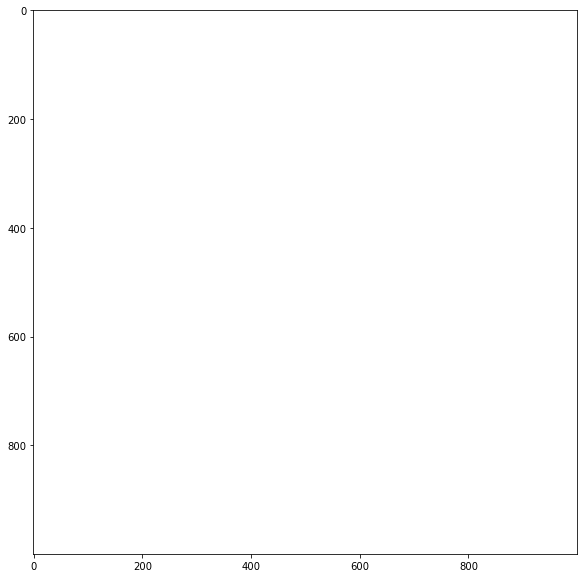

In [30]:
# To check the results for level 3 use colour_lccs_level3 to get the colour scheme.
# WIP: can't get plot to populate, problem with colour scheme maybe?
pyplot.figure(figsize=(12, 10))
red, green, blue, alpha = lccs_l4.colour_lccs_level4(l4_classification_codes)
pyplot.imshow(numpy.dstack([red, green, blue, alpha]))

### **Save results to geotiff**

In [31]:
# # Write out 
# output_rgb_file_name = "Leichhardt_l3_layers.tif"
# out_file_transform = [res_x, 0, min_x, 0, res_y, max_y]
# output_x_size = int((max_x - min_x)/res_x)
# output_y_size = int((min_y - max_y)/res_y)

# # Write RGB colour scheme out
# rgb_dataset = rasterio.open(output_rgb_file_name, 'w', driver='GTiff',
#                             height=output_y_size, width=output_x_size,
#                             count=5, dtype=level3.dtype,
#                             crs=crs, transform=out_file_transform)
# rgb_dataset.write(classification_data.vegetat_veg_cat.values.astype(numpy.uint8), 1)
# rgb_dataset.write(classification_data.aquatic_wat_cat.values.astype(numpy.uint8), 2)
# rgb_dataset.write(classification_data.cultman_agr_cat.values.astype(numpy.uint8), 3)
# rgb_dataset.write(classification_data.artific_urb_cat.values.astype(numpy.uint8), 4)
# rgb_dataset.write(classification_data.artwatr_wat_cat.values.astype(numpy.uint8), 5)
# rgb_dataset.close()

In [32]:
# # Write out
# output_rgb_file_name = "level3_test.tif"
# out_file_transform = [res_x, 0, min_x, 0, res_y, max_y]
# output_x_size = int((max_x - min_x)/res_x)
# output_y_size = int((min_y - max_y)/res_y)

# # Write RGB colour scheme out
# rgb_dataset = rasterio.open(output_rgb_file_name, 'w', driver='GTiff',
#                             height=output_y_size, width=output_x_size,
#                             count=3, dtype=level3.dtype,
#                             crs=crs, transform=out_file_transform)
# rgb_dataset.write(red, 1)
# rgb_dataset.write(green, 2)
# rgb_dataset.write(blue, 3)
# rgb_dataset.close()